<a href="https://colab.research.google.com/github/YashkumarBhatt/Unified-Mentor-Internship/blob/main/Cybersecurity_Suspicius_Web_Threat_Interactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project aims to analyze cybersecurity data to detect suspicious anomalies and threats, to detect unusual behavior and help prevent possible phishing attacks in the future. The dataset contains web traffic records collected through AWS CloudWatch, aimed at detecting suspicious activities and potential attack attempts. The data were generated by monitoring traffic to a production web server, using various detection rules to identify anomalous patterns. The analysis will start with Exploratory Data Analysis (EDA) to inspect and explore any relationships or unusual behavior among the web activities, followed by an ML model to explore the future attack possibilities.

In [ ]:
# Importing the relevent libraries
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Loading and inspecting the data
cyber_data = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")
cyber_data.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [ ]:
# Checking missing values
cyber_data.isnull().sum()

,0
bytes_in,0
bytes_out,0
creation_time,0
end_time,0
src_ip,0
src_ip_country_code,0
protocol,0
response.code,0
dst_port,0
dst_ip,0


In [ ]:
# Checking the types of data
cyber_data.dtypes

,0
bytes_in,int64
bytes_out,int64
creation_time,object
end_time,object
src_ip,object
src_ip_country_code,object
protocol,object
response.code,int64
dst_port,int64
dst_ip,object


Before Processing to EDA, we will carry out some transformations in our dataset to convert datatypes, create relevent columns and remove mission/duplicate data. Further, we will scale and transform it for ML process so that we can directly work with the same dataset later.

In [ ]:
# Preparing the Data
cyber_data_unique = cyber_data.drop_duplicates()

cyber_data_unique['creation_time']= pd.to_datetime(cyber_data_unique['creation_time'])
cyber_data_unique['end_time']= pd.to_datetime(cyber_data_unique['end_time'])
cyber_data_unique['time']= pd.to_datetime(cyber_data_unique['time'])

cyber_data_unique['src_ip_country_code']= cyber_data_unique['src_ip_country_code'].str.upper()

cyber_data_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip_country_code  282 non-null    object             
 5   protocol             282 non-null    object             
 6   response.code        282 non-null    int64              
 7   dst_port             282 non-null    int64              
 8   rule_names           282 non-null    object             
 9   observation_name     282 non-null    object             
 10  time                 282 non-null    datetime64[ns, UTC]
 11  detection_types      282 non-null    object             
 12  hour                 2

In [ ]:
# Creating the necessary columns through feature engineering
cyber_data_unique['duration_seconds']= (cyber_data_unique['end_time']-
cyber_data_unique['creation_time']).dt.total_seconds()

In [ ]:
# Preparing data for ML through scaling and transformation

scaler = StandardScaler()
scaled_features = scaler.fit_transform(cyber_data_unique[['bytes_in', 'bytes_out', 'duration_seconds']])

encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(cyber_data_unique[['src_ip_country_code']])
scaled_columns = ['scaled_bytes_in', 'scaled_bytes_out', 'scaled_duration_seconds']
encoded_columns = encoder.get_feature_names_out(['src_ip_country_code'])

In [ ]:
# Converting all the data back to the initial dataframe

scaled_df= pd.DataFrame(scaled_features, columns=scaled_columns, index=cyber_data_unique.index)
encoded_df= pd.DataFrame(encoded_features.toarray(), columns=encoded_columns, index=cyber_data_unique.index)

transformed_df= pd.concat([cyber_data_unique, scaled_df, encoded_df], axis=1)

transformed_df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip_country_code,protocol,response.code,dst_port,rule_names,observation_name,...,scaled_bytes_in,scaled_bytes_out,scaled_duration_seconds,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,AE,HTTPS,200,443,Suspicious Web Traffic,Adversary Infrastructure Interaction,...,-0.288219,-0.281223,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,US,HTTPS,200,443,Suspicious Web Traffic,Adversary Infrastructure Interaction,...,-0.282108,-0.260804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,CA,HTTPS,200,443,Suspicious Web Traffic,Adversary Infrastructure Interaction,...,-0.282689,-0.279344,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,US,HTTPS,200,443,Suspicious Web Traffic,Adversary Infrastructure Interaction,...,-0.282197,-0.276161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,NL,HTTPS,200,443,Suspicious Web Traffic,Adversary Infrastructure Interaction,...,-0.287996,-0.277678,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Now in the EDA, we will explore any kind of relationships, trends, correlations and/or outliers through relevant visualizations to gain initial insights about the data.

In [ ]:
# Computing correlation matrix
numeric_df= transformed_df.select_dtypes(include=['float64','int64'])
correlation_matrix_numeric = numeric_df.corr()

correlation_matrix_numeric

,bytes_in,bytes_out,response.code,dst_port,anomaly,duration_seconds,scaled_bytes_in,scaled_bytes_out,scaled_duration_seconds,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US
bytes_in,1.000000,0.997705,NaN,NaN,-0.667207,NaN,1.000000,0.997705,NaN,-0.070559,-0.081670,-0.166488,-0.095333,-0.065939,-0.006827,0.316015
bytes_out,0.997705,1.000000,NaN,NaN,-0.657631,NaN,0.997705,1.000000,NaN,-0.072452,-0.081777,-0.159587,-0.090001,-0.067630,-0.045641,0.327683
response.code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dst_port,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
anomaly,-0.667207,-0.657631,NaN,NaN,1.000000,NaN,-0.667207,-0.657631,NaN,0.058131,0.067233,0.138786,0.078696,0.054173,-0.067392,-0.225373
duration_seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scaled_bytes_in,1.000000,0.997705,NaN,NaN,-0.667207,NaN,1.000000,0.997705,NaN,-0.070559,-0.081670,-0.166488,-0.095333,-0.065939,-0.006827,0.316015
scaled_bytes_out,0.997705,1.000000,NaN,NaN,-0.657631,NaN,0.997705,1.000000,NaN,-0.072452,-0.081777,-0.159587,-0.090001,-0.067630,-0.045641,0.327683
scaled_duration_seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src_ip_country_code_AE,-0.070559,-0.072452,NaN,NaN,0.058131,NaN,-0.070559,-0.072452,NaN,1.000000,-0.069568,-0.143607,-0.081429,-0.056055,-0.064040,-0.200546


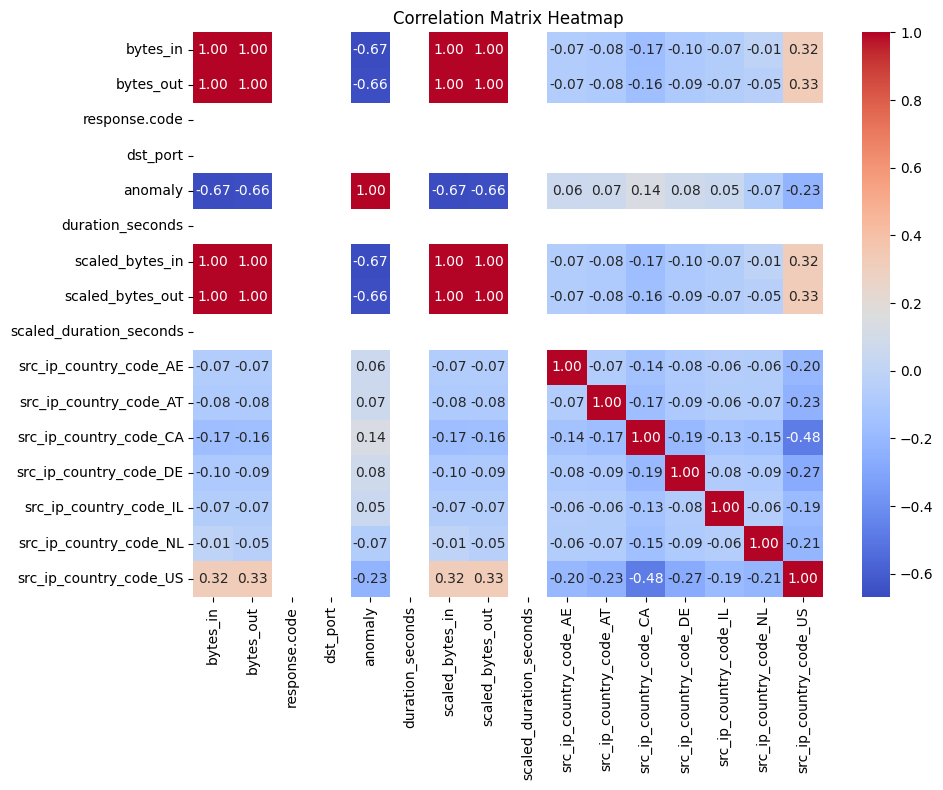

In [ ]:
# Generating a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, fmt = ".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

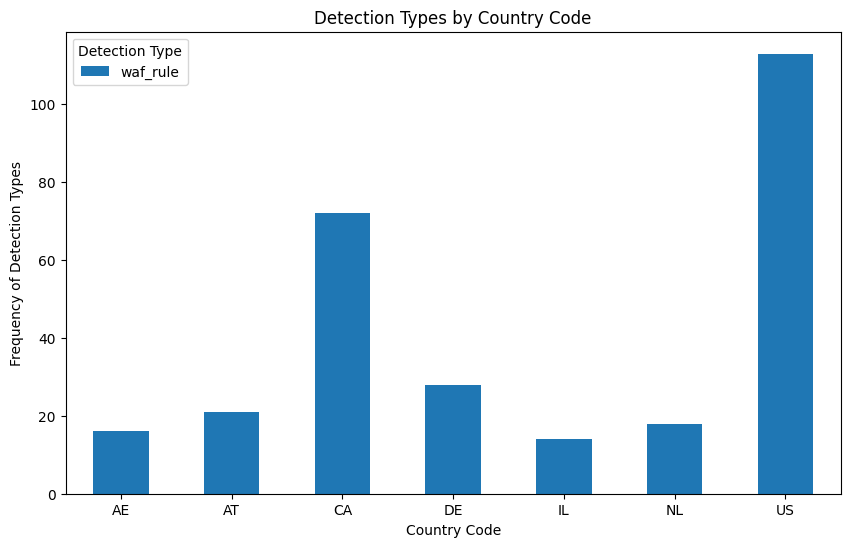

In [ ]:
# Bar chart showing distribution of detection of countrywise anomalies
countrywise_detection_types= pd.crosstab(transformed_df['src_ip_country_code'],transformed_df['detection_types'])
countrywise_detection_types.plot(kind='bar',stacked=True, figsize=(10, 6))
plt.title('Detection Types by Country Code')
plt.xlabel('Country Code')
plt.ylabel('Frequency of Detection Types')
plt.xticks(rotation = 0)
plt.legend(title='Detection Type')
plt.show()

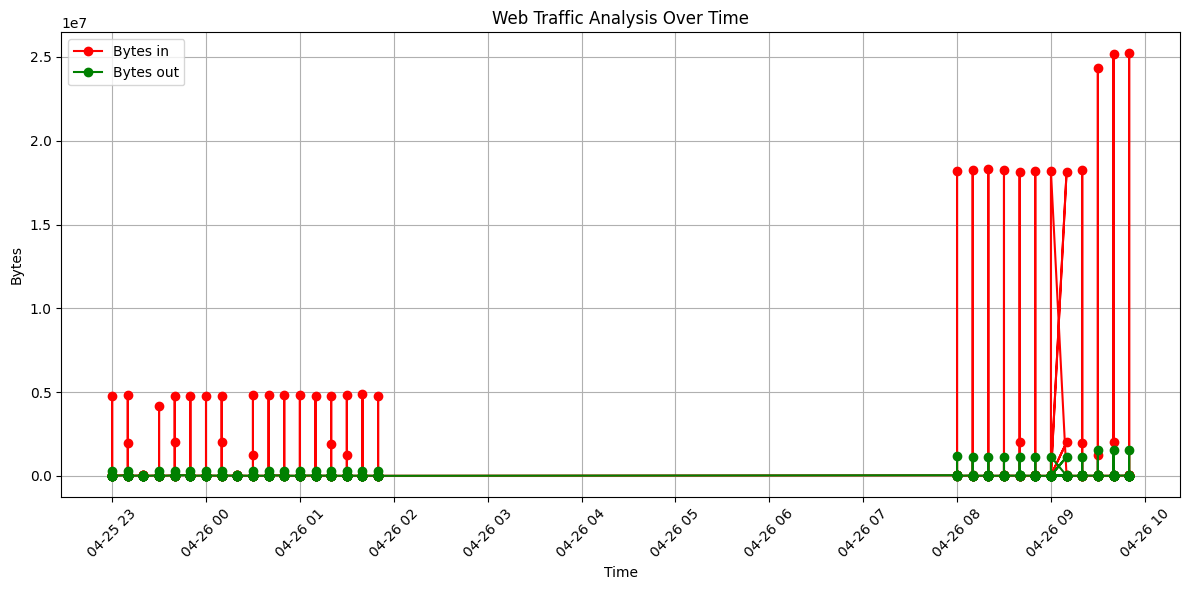

In [ ]:
# Analysis of web traffic over time
plt.figure(figsize=(12, 6))
plt.plot(transformed_df.index, transformed_df['bytes_in'], label= 'Bytes in', marker= 'o', color='red')
plt.plot(transformed_df.index, transformed_df['bytes_out'], label = 'Bytes out', marker= 'o', color='green')
plt.title('Web Traffic Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

The EDA revealed a correlation between different numeric parameters as well as the country that sent the most traffic, that is the US. Also, the web traffic analysis showed a significant number of bytes in compared to bytes out, meaning possible information attacks. Next, we will move on to ML to see if we can model the data to predict any future threats.

In [ ]:
# Assigning data to test and train variables
RandomForestClassifier

transformed_df['is_suspicious']= (transformed_df['detection_types']== 'waf_rule').astype(int)

X = transformed_df[['bytes_in','bytes_out', 'scaled_duration_seconds']]
y = transformed_df['is_suspicious']

In [ ]:
# Splitting the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

# Initializing the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100,random_state=42)

# Trainning the model
rf_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred= rf_classifier.predict(X_test)

In [ ]:
# Evaluating the model accuracy
accuracy= accuracy_score(y_test, y_pred)
classification = classification_report(y_test, y_pred)
print("Model Accuracy: ",accuracy*100, "%")

Model Accuracy:  100.0 %


In [ ]:
# Printing classification report
print("Classification Report: " ,classification)

Classification Report:                precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



Now, we will explore the ML modeliing in Nural Network.

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9625 - loss: 0.6557 - val_accuracy: 1.0000 - val_loss: 0.5835
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.5702 - val_accuracy: 1.0000 - val_loss: 0.5076
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.5079 - val_accuracy: 1.0000 - val_loss: 0.4405
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.4392 - val_accuracy: 1.0000 - val_loss: 0.3654
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.3531 - val_accuracy: 1.0000 - val_loss: 0.2942
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.2849 - val_accuracy: 1.0000 - val_loss: 0.2224
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.2224 - val_accuracy: 1.0000 - val_loss: 0.1636
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.1546 - val_accuracy: 1.0000 - val_loss

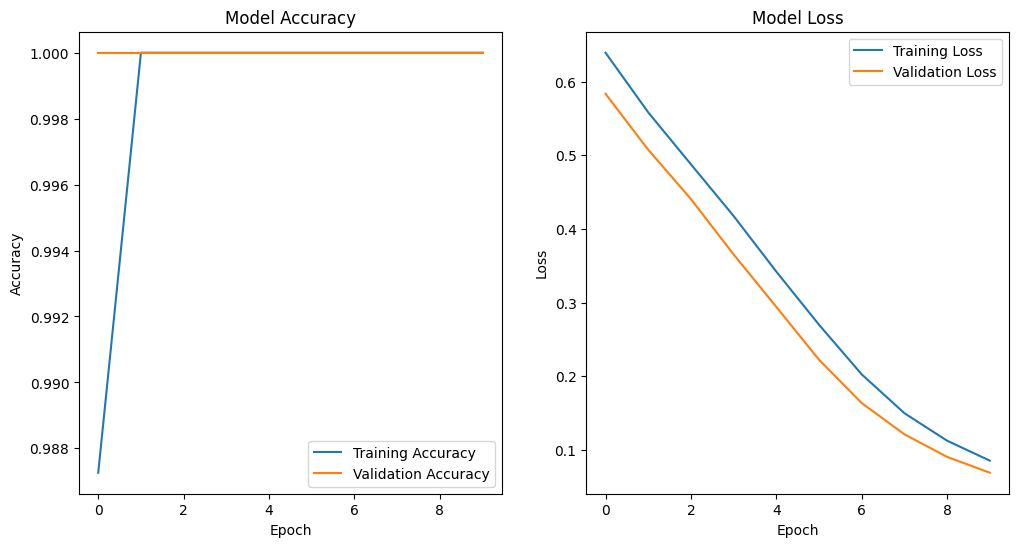

In [ ]:
transformed_df['is_suspicious']= (transformed_df['detection_types'] == 'waf_rule').astype(int)

X= transformed_df[['bytes_in', 'bytes_out']].values
y= transformed_df['is_suspicious'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)


model= Sequential([Dense(8, activation= 'relu', input_shape=(X_train_scaled.shape[1],)), Dense(16, activation= 'relu'), Dense(1, activation= 'sigmoid')])

# Compile the model
model.compile(optimizer=Adam(), loss= 'binary_crossentropy', metrics=['accuracy'])

# Train the model with validation data
history= model.fit(X_train_scaled, y_train, epochs=10,
batch_size=8, verbose=1, validation_data=(X_val_scaled, y_val))
# Evaluate the model
loss, accuracy= model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Plotting the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label= 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label= 'Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label= 'Training Loss')
plt.plot(history.history['val_loss'], label= 'Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Adjusting the network to accommodate the input size
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model= Sequential([Conv1D(32, kernel_size=1, activation='relu', input_shape=(X_train_scaled.shape[1], 1)), Flatten(),Dense(64, activation='relu'),Dropout(0.5),Dense(1, activation='sigmoid')])

In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics = ['accuracy'])

# Train the model
history= model.fit(X_train_scaled, y_train, epochs=10, batch_size=8, verbose=1)

# Evaluate the model
loss, accuracy= model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.2796
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.1469 
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0584 
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0258 
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0126 
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0083 
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0069 
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0046 
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0031 
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0026 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0011  
Test Accuracy: 100.00%


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.1290 - loss: 0.7543 - val_accuracy: 1.0000 - val_loss: 0.6715
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7347 - loss: 0.6596 - val_accuracy: 1.0000 - val_loss: 0.6166
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.5961 - val_accuracy: 1.0000 - val_loss: 0.5650
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.5503 - val_accuracy: 1.0000 - val_loss: 0.5110
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.4993 - val_accuracy: 1.0000 - val_loss: 0.4533
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.4339 - val_accuracy: 1.0000 - val_loss: 0.3902
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.3922 - val_accuracy: 1.0000 - val_loss: 0.3248
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.3118 - val_accuracy: 1.0000 - val_loss: 0.2599


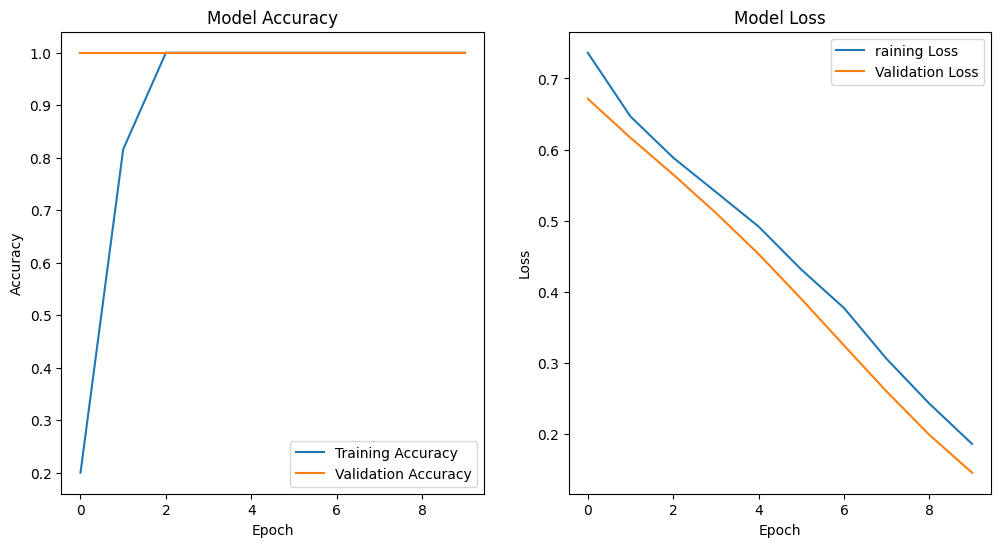

In [ ]:
# Neural network model
model= Sequential([
Dense(128, activation= 'relu',input_shape=(X_train_scaled.shape[1],)),Dropout(0.5),Dense(128, activation='relu'), Dropout(0.5),Dense(1, activation='sigmoid')])

# Compile the model
model.compile(optimizer=Adam(), loss = 'binary_crossentropy', metrics=['accuracy'])

# Train the model
history= model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

# Evaluate the model
loss, accuracy= model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Plotting the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label= 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label= 'Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label= 'training Loss')
plt.plot(history.history['val_loss'], label= 'Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9832 - loss: 0.6318 - val_accuracy: 1.0000 - val_loss: 0.6047
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.5957 - val_accuracy: 1.0000 - val_loss: 0.5618
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.5407 - val_accuracy: 1.0000 - val_loss: 0.5194
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.4953 - val_accuracy: 1.0000 - val_loss: 0.4770
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.4621 - val_accuracy: 1.0000 - val_loss: 0.4339
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.4241 - val_accuracy: 1.0000 - val_loss: 0.3910
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.3694 - val_accuracy: 1.0000 - val_loss: 0.3483
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.3356 - val_accuracy: 1.0000 - val_loss: 0.3058


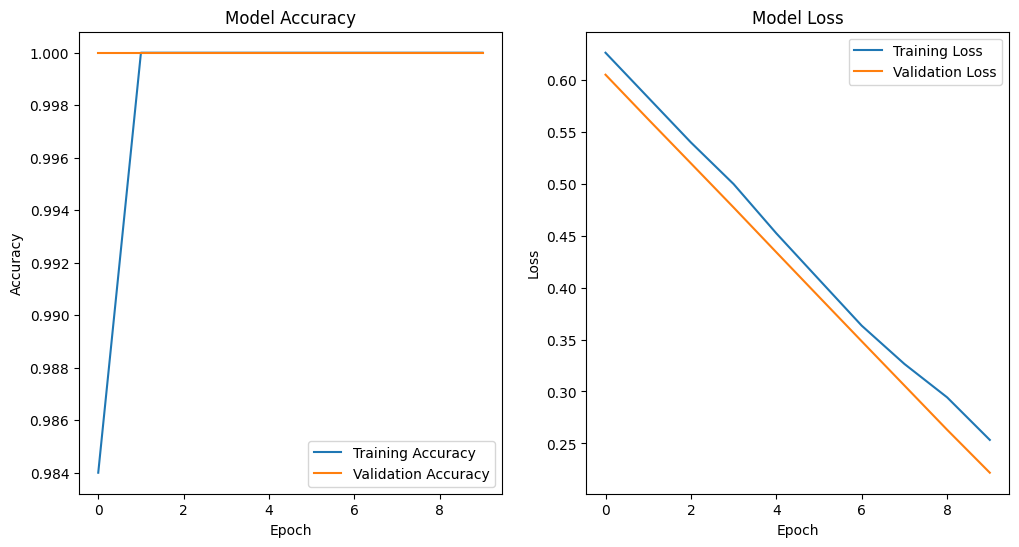

In [ ]:
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled= scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Adjusting the network to accommodate the input size
model= Sequential([Conv1D(32, kernel_size=1, activation='relu', input_shape=(X_train_scaled.shape[1], 1)), Flatten(),Dense(64, activation='relu'),Dropout(0.5),Dense(1, activation='sigmoid')])

# Compile the model
model.compile(optimizer=Adam(), loss= 'binary_crossentropy', metrics=['accuracy'])

# Train the model
history= model.fit(X_train_scaled, y_train, epochs=10,batch_size=32, verbose=1, validation_split=0.2)

# Evaluate the model
loss, accuracy= model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Plotting the training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label= 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label= 'Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label= 'Training Loss')
plt.plot(history.history['val_loss'], label= 'Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()